In [1]:
from ast import arg

import matplotlib.cbook as cbook
import random
import analysis_utils
import itertools
import copy
import os

from analysis_utils import*
import numpy as np
import json
import matplotlib.pyplot as plt
from collections import defaultdict

from scipy.stats import mannwhitneyu

In [68]:
!hostname

c1b01


In [2]:
model = 'NonlinearHC_SIR'
path = f'{model}_avg'
index = 'range'
netType = 'realNet'
fileNames = {1: {'net': 1, 'paraClass': 1, 'exprClass': 2}, 
 2: {'net': 2, 'paraClass': 1, 'exprClass': 2}, 
 3: {'net': 3, 'paraClass': 1, 'exprClass': 2}, 
 4: {'net': 4, 'paraClass': 1, 'exprClass': 2}, 
 5: {'net': 5, 'paraClass': 1, 'exprClass': 2}, 
 6: {'net': 6, 'paraClass': 1, 'exprClass': 2}, 
 7: {'net': 7, 'paraClass': 1, 'exprClass': 2}, 
 8: {'net': 8, 'paraClass': 1, 'exprClass': 2}, 
 9: {'net': 9, 'paraClass': 1, 'exprClass': 2}, 
 10: {'net': 10, 'paraClass': 1, 'exprClass': 2}, 
 11: {'net': 11, 'paraClass': 1, 'exprClass': 2}, 
 12: {'net': 12, 'paraClass': 1, 'exprClass': 2}, 
 13: {'net': 13, 'paraClass': 1, 'exprClass': 2}, 
 14: {'net': 14, 'paraClass': 1, 'exprClass': 2}, 
 15: {'net': 15, 'paraClass': 1, 'exprClass': 2}, 
 16: {'net': 16, 'paraClass': 1, 'exprClass': 2}, 
 17: {'net': 17, 'paraClass': 1, 'exprClass': 2}, 
 18: {'net': 18, 'paraClass': 1, 'exprClass': 2}, 
 19: {'net': 19, 'paraClass': 1, 'exprClass': 2}, 
 20: {'net': 20, 'paraClass': 1, 'exprClass': 2}}
nodeNumDic = {1: 1718, 2: 1290, 3: 420, 4: 580, 5: 1104, 
              6: 294, 7: 282, 8: 143, 9: 979, 10: 339, 
              11: 591, 12: 217, 13: 76, 14: 242, 15: 403, 
              16: 327, 17: 663, 18: 130, 19: 1044, 20: 456}

In [14]:
"""100%"""
# Randomly select toprN nodes for each metric calculation
fLst = np.linspace(0.01, 1, 100)
methods = ['degree',  'clsBetweenness', 'clsCloseness', 'clsKcore', 'clsEigenvector',
           'KMcore_g1', 'KMcore_gf', 
                'nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 'neiNodesNum', 
                'new_neiNodeSum_1',
                 
            ] 
jaccardDic = dict()  
meanIndexDic = dict()
errFuncDic = dict()
rcgRtoDic = dict()
tauDic = dict()
for net in fileNames:
    #print(net)
    jaccardDic[net] = dict()
    meanIndexDic[net] = dict()
    errFuncDic[net] = dict()
    rcgRtoDic[net] = dict()
    tauDic[net] = dict()
    para = fileNames[net]['paraClass']
    expr = fileNames[net]['exprClass']
    fname = f'avg_{net}_para{para}_expr{expr}_{index}'
    with open(f'{path}/{fname}.json', "r") as g:
        avgDic = json.load(g)
    for ms in methods:
        jaccardDic[net][ms] = []
        meanIndexDic[net][ms] = []
        errFuncDic[net][ms] = []
        rcgRtoDic[net][ms] = []
        with open(f'../MeasureValuesRanking/NodesMeasures/h_{ms}_{netType}_{net}.json', "r") as h:
            msDic = json.load(h)
        tauDic[net][ms] = round(caltau(avgDic, msDic, 'b'), 5)
        if nodeNumDic[net]>=2*len(fLst):
            for f in fLst:
                num = int(f*nodeNumDic[net])
                gdr =  chooseTopNodes_groundTruth(path, fname, num)
                msnodes = chooseTopNodes_h_realNet(net, ms, num)
                jcd = len(set(gdr) & set(msnodes))/len(set(gdr) | set(msnodes))
                mdx = sum([avgDic[f'{_}'] for _ in msnodes])/(num*nodeNumDic[net])
                erf = sum([avgDic[f'{_}'] for _ in msnodes])/sum([avgDic[f'{_}'] for _ in gdr])
                rcg = len(set(gdr) & set(msnodes))/len(set(gdr))
                jaccardDic[net][ms].append(jcd)
                meanIndexDic[net][ms].append(mdx)
                errFuncDic[net][ms].append(erf)
                rcgRtoDic[net][ms].append(rcg)
        else:
            if nodeNumDic[net]%2 == 1:
                sequ = range(1,int(nodeNumDic[net]*1)+1, 2)
            else:
                sequ = range(2,int(nodeNumDic[net]*1)+2, 2)
            for num in sequ:
                gdr =  chooseTopNodes_groundTruth(path, fname, num)
                msnodes = chooseTopNodes_h_realNet(net, ms, num)
                jcd = len(set(gdr) & set(msnodes))/len(set(gdr) | set(msnodes))
                mdx = sum([avgDic[f'{_}'] for _ in msnodes])/(num*nodeNumDic[net])
                erf = sum([avgDic[f'{_}'] for _ in msnodes])/sum([avgDic[f'{_}'] for _ in gdr])
                rcg = len(set(gdr) & set(msnodes))/len(set(gdr))
                jaccardDic[net][ms].append(jcd)
                meanIndexDic[net][ms].append(mdx)
                errFuncDic[net][ms].append(erf)
                rcgRtoDic[net][ms].append(rcg)

In [4]:
colors = {
          'new_neiNodeSum_1': 'red',
          'degree': 'darkblue', # 'royalblue',
          'clsBetweenness': (168/255, 163/255, 219/255),# plt.cm.tab20(8), #'lavender', 
          'clsCloseness': (198/255, 143/255, 198/255), # 'thistle',  
          'clsKcore':(197/255, 215/255, 192/255), 
          'clsEigenvector': (255/255, 222/255, 153/255), # 'navajowhite', 
          'KMcore_g1': 'darkolivegreen', #'seagreen',
          'KMcore_gf': 'darkgreen', # 'darkolivegreen', 
          'neiNodesNum': (156/255, 176/255, 202/255) , #'lightsteelblue', # 'powderblue', 
          'nodeEdgeEigenvector_linear': (164/255, 114/255, 11/255), # 'darkgoldenrod', # 'darksalmon',  # 'gold',
          'nodeEdgeEigenvector_max': (255/255, 120/255, 0), # 'darkorange',
           }

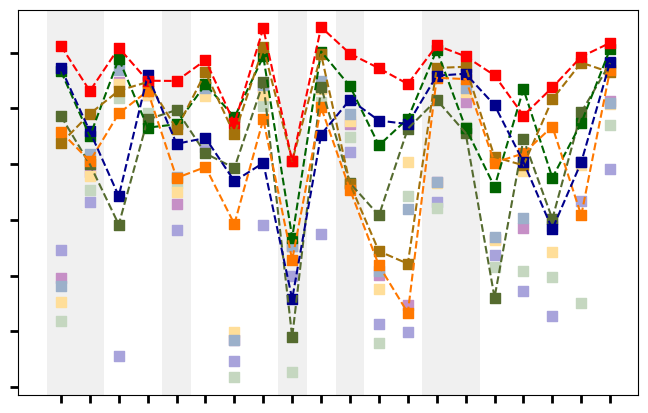

In [8]:
methods_ = [ 'clsBetweenness', 'clsCloseness', 'clsKcore','clsEigenvector','neiNodesNum',
                 'KMcore_g1', 'KMcore_gf',
            'nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 
             'degree', 'new_neiNodeSum_1',]
netrank = {1:1, 2:2, 3:5, 4:19, 5:9, 6:17, 7:11, 8:4, 9:20, 10:3,11:15, 12:10,13:16,14:6,15:7,16:14,17:12,18:8,19:18,20:13} 
plt.figure(figsize=(8,5))

plt.axvspan(0.5, 1.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
plt.axvspan(1.5, 2.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
plt.axvspan(4.5, 5.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
plt.axvspan(8.5, 9.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
plt.axvspan(10.5, 11.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
plt.axvspan(13.5, 14.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
plt.axvspan(14.5, 15.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)
for mtd in methods_:
    x = []
    y = []
    for net in netrank:
        x.append(net)
        y.append(tauDic[netrank[net]][mtd])
    plt.scatter(x, y, label=f'{mtd}', color=colors[mtd], marker='s',s=50)
    if mtd in ['new_neiNodeSum_1', 'KMcore_g1', 'KMcore_gf', 'nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max','degree'] :
        plt.plot(x, y, label=f'{mtd}', color=colors[mtd], linestyle='dashed')


plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
# plt.xlabel("Hypergraph",fontsize=14)
# plt.ylabel(r"$\tau$",fontsize=14, fontweight='bold')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.tick_params(axis='y', labelsize=16)  
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='x', which='major', size=6, width=2)  
plt.tick_params(axis='y', which='major', size=6, width=2)  
# plt.legend()
plt.savefig(f'savefig_all/tau_bar_span.svg', format='svg', bbox_inches='tight',dpi=300)
plt.show()

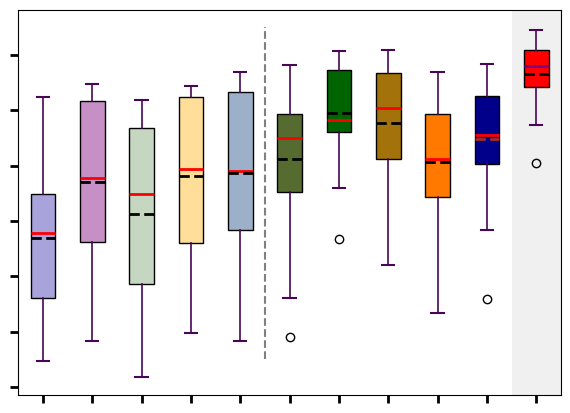

In [9]:
methods_plt = [ 'clsBetweenness', 'clsCloseness', 'clsKcore','clsEigenvector','neiNodesNum',
                 'KMcore_g1', 'KMcore_gf',
            'nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 
             'degree', 'new_neiNodeSum_1']

data_all = []
for m in methods_plt:
    data = []
    for n in fileNames:
        data.append(tauDic[n][m])
    data_all.append(data)
plt.figure(figsize=(7,5))

plt.axvspan(10.5, 11.5, color=(235/255, 235/255, 235/255), alpha=0.7, lw=0)

f = plt.boxplot(data_all, 
            # labels=labels_lst,
            patch_artist=True,  
            medianprops={'linestyle': '-', 'color': 'r', 'linewidth': 2},  
            showmeans=True, 
            meanline=True,
            meanprops={      
            'color': 'black', 'linewidth': 2},
            whiskerprops={'linestyle': '-', 'linewidth': 1.2, 'color': '#480656'},
            capprops={'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'}
            )

colorlst = [colors[_] for _ in methods_plt]
for patch, color in zip(f['boxes'], colorlst):
    patch.set_facecolor(color)
# degree
f['medians'][9].set_color('r')
f['medians'][9].set_linestyle('-')
f['means'][9].set_color('brown')

# IPS
f['medians'][10].set_color('purple')
f['medians'][10].set_linestyle('-')
f['means'][10].set_color('black')

plt.vlines(x=5.5, ymin=0.35, ymax=0.95,color='gray', linestyle='--', linewidth=1.5)

plt.tick_params(axis='y', labelsize=16)  
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='x', which='major', size=6, width=2)  
plt.tick_params(axis='y', which='major', size=6, width=2) 
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])

plt.savefig(f'savefig_all/box_span.svg', format='svg', bbox_inches='tight',dpi=300)
plt.show()

In [5]:
yticksDic = {
1:[0.7,0.75,0.8,0.85,0.9,0.95,1.0], # [0.5,0.6,0.7,0.8,0.9,1.0],
2:[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
3:[0.75,0.8,0.85,0.9,0.95,1.0],
4:[0.75,0.8,0.85,0.9,0.95,1.0],
5:[0.5,0.6,0.7,0.8,0.9,1.0],
6:[0.9,0.92,0.94,0.96,0.98,1.0],
7:[0.0,0.2,0.4,0.6,0.8,1.0],
8:[0.0,0.2,0.4,0.6,0.8,1.0],
9:[0.0,0.2,0.4,0.6,0.8,1.0],
10:[0.5,0.6,0.7,0.8,0.9,1.0],
11:[0.0,0.2,0.4,0.6,0.8,1.0],
12:[0.0,0.2,0.4,0.6,0.8,1.0],
13:[0.9,0.92,0.94,0.96,0.98,1.0],
14:[0.875,0.9,0.925,0.95,0.975,1.0],
15:[0.9,0.92,0.94,0.96,0.98,1.0],
16:[0.5,0.6,0.7,0.8,0.9,1.0],
17:[0.4,0.5,0.6,0.7,0.8,0.9,1.0],
18:[0.5,0.6,0.7,0.8,0.9,1.0],
19:[0.0,0.2,0.4,0.6,0.8,1.0],
20:[0.5,0.6,0.7,0.8,0.9,1.0],
             }

1


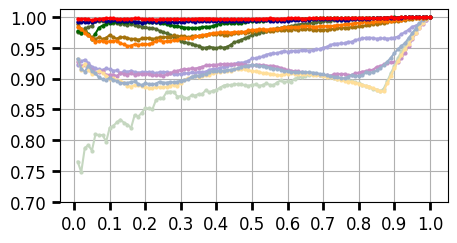

2


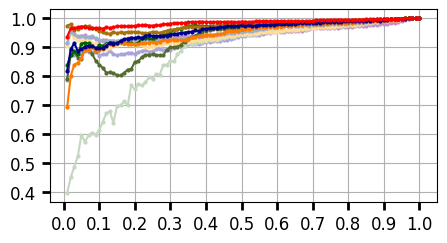

3


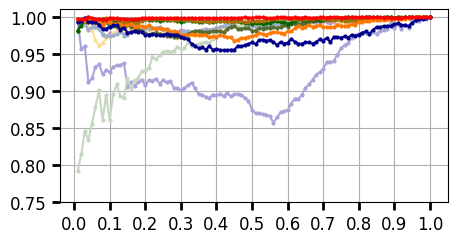

4


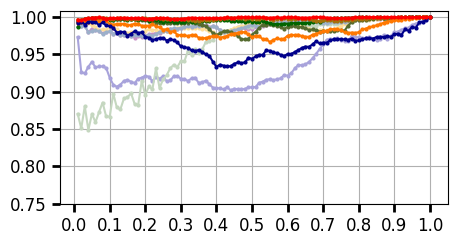

5


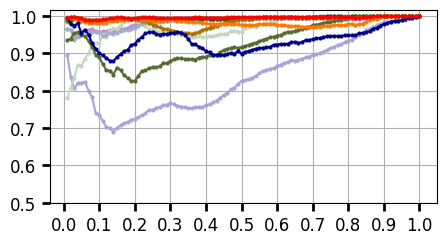

6


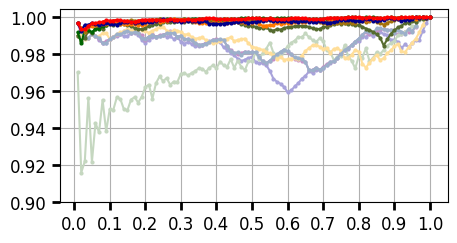

7


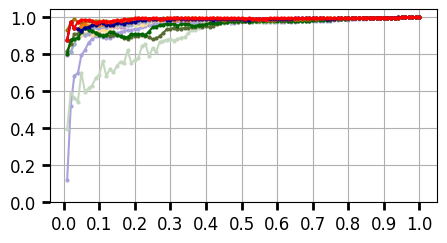

8


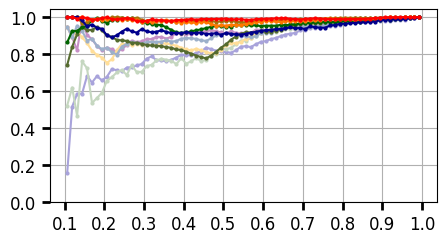

9


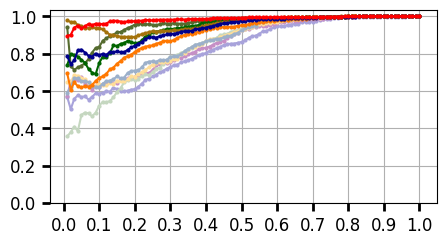

10


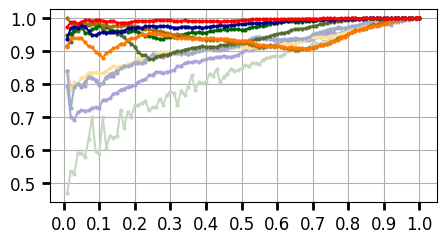

11


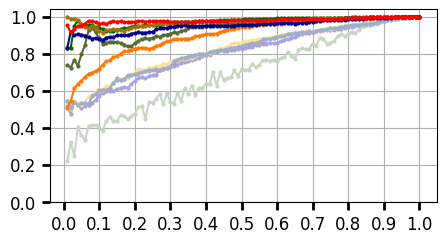

12


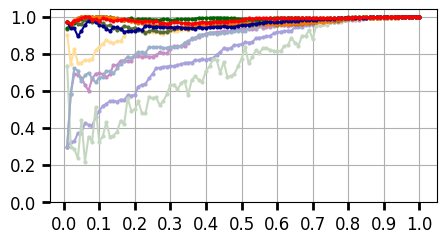

13


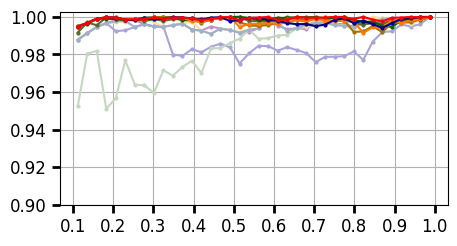

14


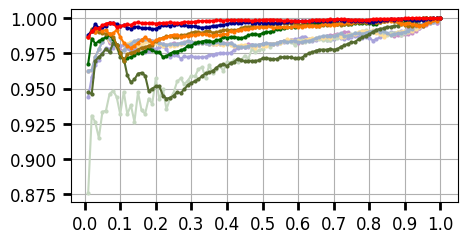

15


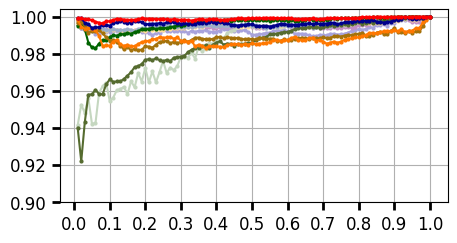

16


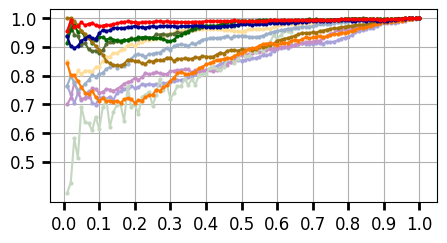

17


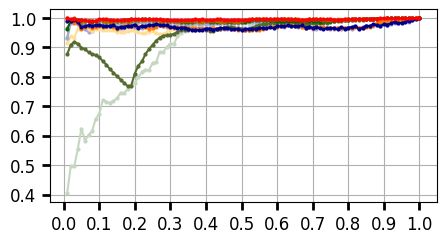

18


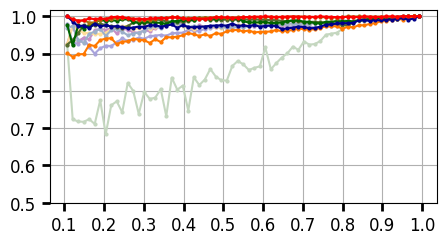

19


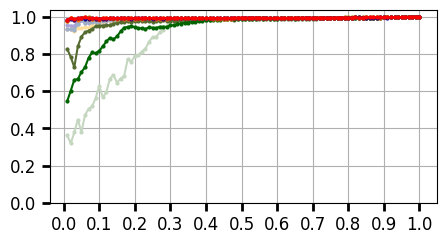

20


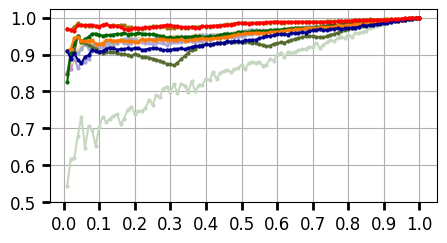

In [15]:
# errFunc
methods_plt = [ 'clsBetweenness', 'clsCloseness', 
               'clsKcore',  'KMcore_g1', 'KMcore_gf',
            'clsEigenvector','nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 
             'degree','neiNodesNum', 'new_neiNodeSum_1']
labels = {
          'new_neiNodeSum_1':'MIS', 
          'degree':'Degree',
          'clsBetweenness':'Betweenness', 
          'clsCloseness':'Closeness', 
          'clsKcore':'K-coreness', 
          'clsEigenvector':'Eigenvector', 
          'KMcore_g1':'H-coreness-R', 
          'KMcore_gf':'H-coreness-$R_w$', 
          'neiNodesNum':'NNum', 
          'nodeEdgeEigenvector_linear':'NEE_linear', 
          'nodeEdgeEigenvector_max':'NEE_max',
          }
title_netname = {1:'congress-bills',2:'house-committees',3:'algebra-questions',4:'geometry-questions',5:'music-review',
                 6:'senate-bills', 7:'senate-committees', 8:'email-Enron',9:'email-EU', 10:'Elem1',
                 11:'Mid1',12:'InVS15',13:'LH10',14:'LyonSchool',15:'SFHH',
                 16:'Thiers13', 17:'M_PL_015_ins', 18:'M_PL_015-pI', 19:'M PL_062_ins', 20:'M _PL_062-pl'}
marker = 'o'
size = 2
me = 1
fontsize1 = 12
fontsize2 = 18
fontsize3 = 18
fontweight = 'bold'
for n in range(1,21):
    print(n)
    plt.figure(figsize=(5,2.5))
    if nodeNumDic[n]>=2*len(fLst):
        plt.plot(fLst, errFuncDic[n]['clsBetweenness'], label = labels['clsBetweenness'],
                 color=colors['clsBetweenness'], marker=marker, markersize= size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['clsCloseness'], label = labels['clsCloseness'] ,
                 color=colors['clsCloseness'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['clsKcore'], label = labels['clsKcore'],
                 color=colors['clsKcore'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['clsEigenvector'], label = labels['clsEigenvector'],
                 color=colors['clsEigenvector'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['neiNodesNum'], label = labels['neiNodesNum'],
                 color=colors['neiNodesNum'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['KMcore_g1'], label = labels['KMcore_g1'],
                 color=colors['KMcore_g1'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['KMcore_gf'], label = labels['KMcore_gf'],
                 color=colors['KMcore_gf'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['nodeEdgeEigenvector_linear'], label = labels['nodeEdgeEigenvector_linear'],
                 color=colors['nodeEdgeEigenvector_linear'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['nodeEdgeEigenvector_max'], label = labels['nodeEdgeEigenvector_max'],
                 color=colors['nodeEdgeEigenvector_max'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['degree'], label = labels['degree'],
                 color=colors['degree'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, errFuncDic[n]['new_neiNodeSum_1'], label = labels['new_neiNodeSum_1'],
                 color=colors['new_neiNodeSum_1'], marker=marker, markersize=size, markevery=me)

        plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
        plt.yticks(yticksDic[n])
        plt.tick_params(axis='y', labelsize=fontsize1)  
        plt.tick_params(axis='x', labelsize=fontsize1)
        plt.tick_params(axis='y', which='major', size=6, width=2)  
        plt.tick_params(axis='x', which='major', size=6, width=2)  
        plt.grid()
        plt.savefig(f'savefig_all/err_fig2_net{n}_grid.svg', format='svg', bbox_inches='tight',dpi=300)
        plt.show()
    else:
        if nodeNumDic[net]%2 == 1:
            numLst = range(1,int(nodeNumDic[net]*1)+1, 2)
        else:
            numLst = range(2,int(nodeNumDic[net]*1)+2, 2)
        numLst = range(1,int(nodeNumDic[n])+1,2)
        plt.plot(numLst, errFuncDic[n]['clsBetweenness'], label = labels['clsBetweenness'],
                 color=colors['clsBetweenness'], marker=marker, markersize= size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['clsCloseness'], label = labels['clsCloseness'] ,
                 color=colors['clsCloseness'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['clsKcore'], label = labels['clsKcore'],
                 color=colors['clsKcore'] , marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['clsEigenvector'], label = labels['clsEigenvector'],
                 color=colors['clsEigenvector'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['neiNodesNum'], label = labels['neiNodesNum'],
                 color=colors['neiNodesNum'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['KMcore_g1'], label = labels['KMcore_g1'],
                 color=colors['KMcore_g1'] , marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['KMcore_gf'], label = labels['KMcore_gf'],
                 color=colors['KMcore_gf'] , marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['nodeEdgeEigenvector_linear'], label = labels['nodeEdgeEigenvector_linear'],
                 color=colors['nodeEdgeEigenvector_linear'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['nodeEdgeEigenvector_max'], label = labels['nodeEdgeEigenvector_max'],
                 color=colors['nodeEdgeEigenvector_max'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['degree'], label = labels['degree'],
                 color=colors['degree'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, errFuncDic[n]['new_neiNodeSum_1'], label = labels['new_neiNodeSum_1'],
                 color=colors['new_neiNodeSum_1'], marker=marker, markersize=size, markevery=me)


        tick_positions = np.linspace(0, 2*len(numLst), 10)
        tick_labels = [f"{i/10:.1f}" for i in range(1, 11)]
        plt.xticks(tick_positions, tick_labels)
        # plt.xticks(numLst)
        plt.yticks(yticksDic[n])
        plt.tick_params(axis='y', labelsize=fontsize1)  # 设置刻度标签大小
        plt.tick_params(axis='x', labelsize=fontsize1)
        plt.tick_params(axis='y', which='major', size=6, width=2)  # 设置刻度线大小和宽度
        plt.tick_params(axis='x', which='major', size=6, width=2)  # 设置刻度线大小和宽度
        # plt.gca().set_xticklabels([])
        # plt.gca().set_yticklabels([])
        plt.grid()
        plt.savefig(f'savefig_all/err_fig2_net{n}_grid.svg', format='svg', bbox_inches='tight',dpi=300)
        plt.show()
        # ipt = input()



1


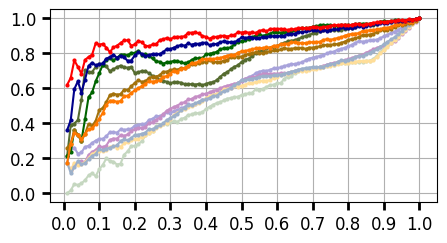

2


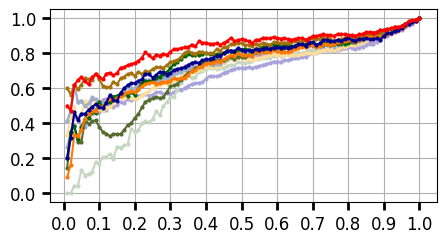

3


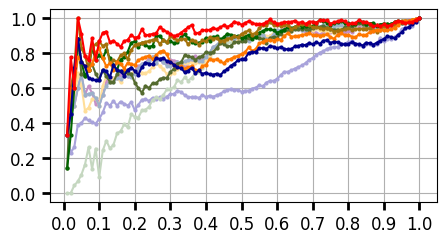

4


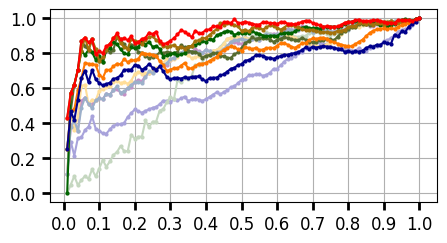

5


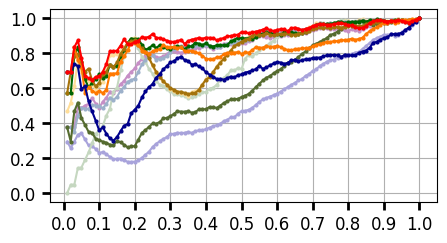

6


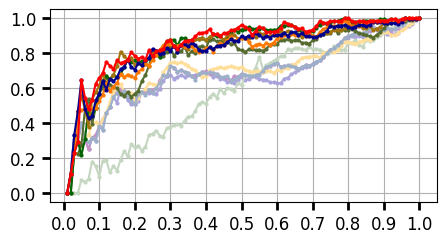

7


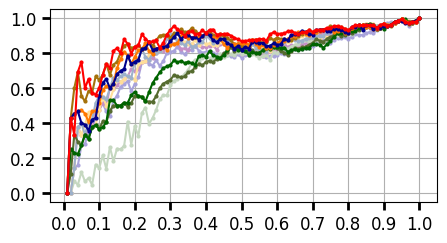

8


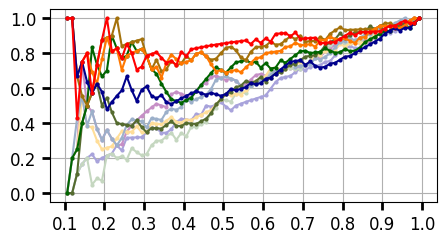

9


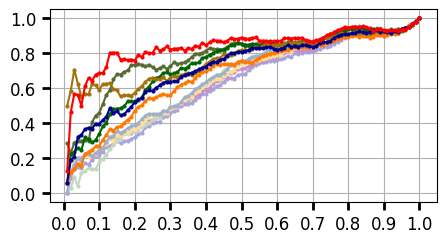

10


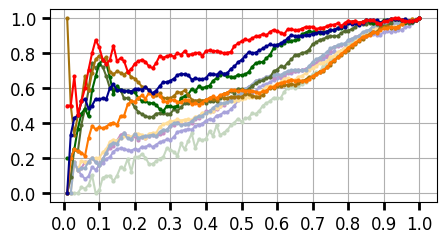

11


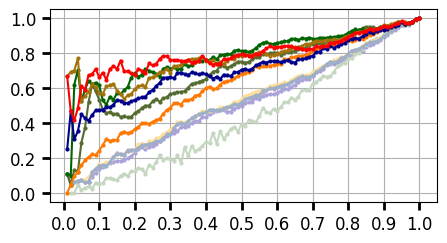

12


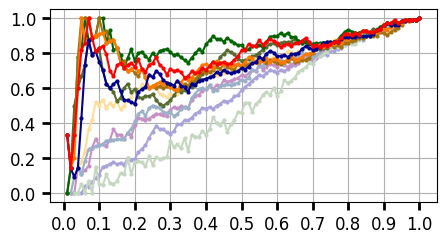

13


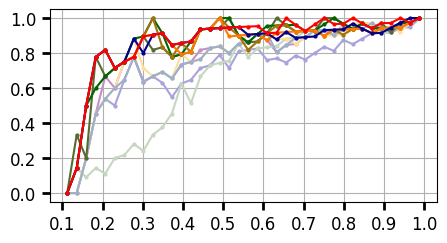

14


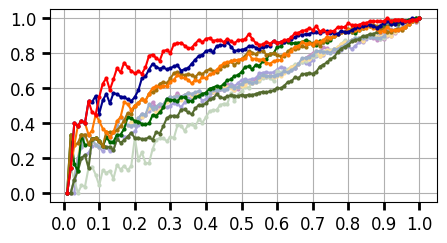

15


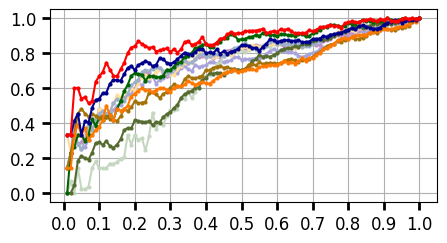

16


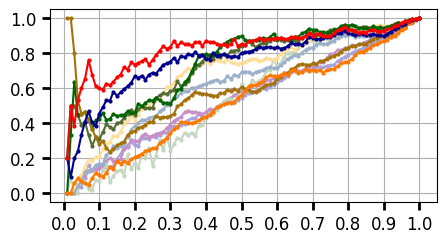

17


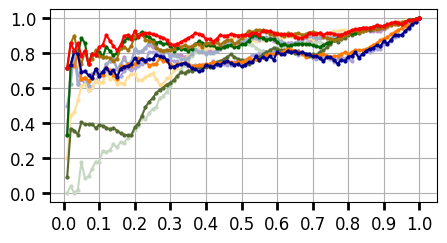

18


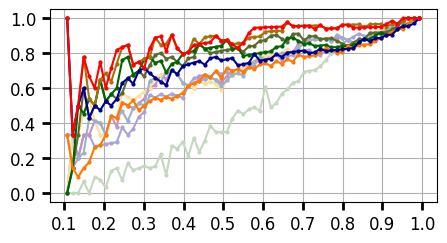

19


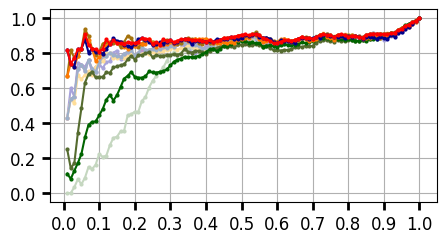

20


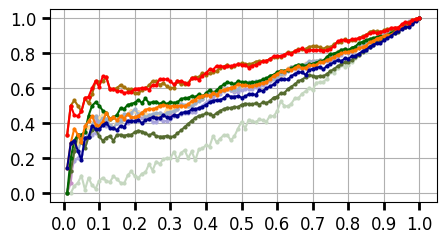

In [16]:
# jaccardDic
methods_plt = [ 'clsBetweenness', 'clsCloseness', 
               'clsKcore',  'KMcore_g1', 'KMcore_gf',
            'clsEigenvector','nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 
             'degree','neiNodesNum', 'new_neiNodeSum_1',]
labels = {
          'new_neiNodeSum_1':'MIS', 
          'degree':'Degree',
          'clsBetweenness':'Betweenness', 
          'clsCloseness':'Closeness', 
          'clsKcore':'K-coreness', 
          'clsEigenvector':'Eigenvector', 
          'KMcore_g1':'H-coreness-R', 
          'KMcore_gf':'H-coreness-$R_w$', 
          'neiNodesNum':'NNum', 
          'nodeEdgeEigenvector_linear':'NEE_linear', 
          'nodeEdgeEigenvector_max':'NEE_max',
           }
title_netname = {1:'congress-bills',2:'house-committees',3:'algebra-questions',4:'geometry-questions',5:'music-review',
                 6:'senate-bills', 7:'senate-committees', 8:'email-Enron',9:'email-EU', 10:'Elem1',
                 11:'Mid1',12:'InVS15',13:'LH10',14:'LyonSchool',15:'SFHH',
                 16:'Thiers13', 17:'M_PL_015_ins', 18:'M_PL_015-pI', 19:'M PL_062_ins', 20:'M _PL_062-pl'}
marker = 'o'
size = 2
me = 1
fontsize1 = 12
fontsize2 = 18
fontsize3 = 18
fontweight = 'bold'
for n in range(1,21):
    print(n)
    plt.figure(figsize=(5,2.5))
    if nodeNumDic[n]>=2*len(fLst):
        plt.plot(fLst, jaccardDic[n]['clsBetweenness'], label = labels['clsBetweenness'],
                 color=colors['clsBetweenness'], marker=marker, markersize= size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['clsCloseness'], label = labels['clsCloseness'] ,
                 color=colors['clsCloseness'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['clsKcore'], label = labels['clsKcore'],
                 color=colors['clsKcore'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['clsEigenvector'], label = labels['clsEigenvector'],
                 color=colors['clsEigenvector'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['neiNodesNum'], label = labels['neiNodesNum'],
                 color=colors['neiNodesNum'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['KMcore_g1'], label = labels['KMcore_g1'],
                 color=colors['KMcore_g1'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['KMcore_gf'], label = labels['KMcore_gf'],
                 color=colors['KMcore_gf'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['nodeEdgeEigenvector_linear'], label = labels['nodeEdgeEigenvector_linear'],
                 color=colors['nodeEdgeEigenvector_linear'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['nodeEdgeEigenvector_max'], label = labels['nodeEdgeEigenvector_max'],
                 color=colors['nodeEdgeEigenvector_max'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['degree'], label = labels['degree'],
                 color=colors['degree'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['new_neiNodeSum_1'], label = labels['new_neiNodeSum_1'],
                 color=colors['new_neiNodeSum_1'], marker=marker, markersize=size, markevery=me)


        plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
        plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        plt.tick_params(axis='y', labelsize=fontsize1) 
        plt.tick_params(axis='x', labelsize=fontsize1)
        plt.tick_params(axis='y', which='major', size=6, width=2) 
        plt.tick_params(axis='x', which='major', size=6, width=2)  

        plt.grid()
        plt.savefig(f'savefig_all/jac_fig2_net{n}_grid.svg', format='svg', bbox_inches='tight',dpi=300)
        plt.show()
    else:
        if nodeNumDic[net]%2 == 1:
            numLst = range(1,int(nodeNumDic[net]*1)+1, 2)
        else:
            numLst = range(2,int(nodeNumDic[net]*1)+2, 2)
        numLst = range(1,int(nodeNumDic[n])+1,2)
        plt.plot(numLst, jaccardDic[n]['clsBetweenness'], label = labels['clsBetweenness'],
                 color=colors['clsBetweenness'], marker=marker, markersize= size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['clsCloseness'], label = labels['clsCloseness'] ,
                 color=colors['clsCloseness'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['clsKcore'], label = labels['clsKcore'],
                 color=colors['clsKcore'] , marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['clsEigenvector'], label = labels['clsEigenvector'],
                 color=colors['clsEigenvector'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['neiNodesNum'], label = labels['neiNodesNum'],
                 color=colors['neiNodesNum'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['KMcore_g1'], label = labels['KMcore_g1'],
                 color=colors['KMcore_g1'] , marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['KMcore_gf'], label = labels['KMcore_gf'],
                 color=colors['KMcore_gf'] , marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['nodeEdgeEigenvector_linear'], label = labels['nodeEdgeEigenvector_linear'],
                 color=colors['nodeEdgeEigenvector_linear'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['nodeEdgeEigenvector_max'], label = labels['nodeEdgeEigenvector_max'],
                 color=colors['nodeEdgeEigenvector_max'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['degree'], label = labels['degree'],
                 color=colors['degree'], marker=marker, markersize=size, markevery=me)
        plt.plot(numLst, jaccardDic[n]['new_neiNodeSum_1'], label = labels['new_neiNodeSum_1'],
                 color=colors['new_neiNodeSum_1'], marker=marker, markersize=size, markevery=me)

        tick_positions = np.linspace(0, 2*len(numLst), 10)
        tick_labels = [f"{i/10:.1f}" for i in range(1, 11)]
        plt.xticks(tick_positions, tick_labels)
        plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        plt.tick_params(axis='y', labelsize=fontsize1)  
        plt.tick_params(axis='x', labelsize=fontsize1)
        plt.tick_params(axis='y', which='major', size=6, width=2)  #
        plt.tick_params(axis='x', which='major', size=6, width=2) 

        plt.grid()
        plt.savefig(f'savefig_all/jac_fig2_net{n}_grid.svg', format='svg', bbox_inches='tight',dpi=300)
        plt.show()



In [17]:
fLst = np.linspace(0.01, 0.5, 50)
methods = ['degree', 'clsBetweenness', 'clsCloseness', 'clsKcore', 'clsEigenvector',
           'KMcore_g1', 'KMcore_gf', 
                'nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 'neiNodesNum', 'new_neiNodeSum_1',
                 
            ] 
jaccardDic = dict()  
meanIndexDic = dict()
errFuncDic = dict()
rcgRtoDic = dict()
tauDic = dict()
for net in fileNames:
    #print(net)
    jaccardDic[net] = dict()
    meanIndexDic[net] = dict()
    errFuncDic[net] = dict()
    rcgRtoDic[net] = dict()
    tauDic[net] = dict()
    para = fileNames[net]['paraClass']
    expr = fileNames[net]['exprClass']
    fname = f'avg_{net}_para{para}_expr{expr}_{index}'
    with open(f'{path}/{fname}.json', "r") as g:
        avgDic = json.load(g)
    for ms in methods:
        jaccardDic[net][ms] = []
        meanIndexDic[net][ms] = []
        errFuncDic[net][ms] = []
        rcgRtoDic[net][ms] = []
        with open(f'../MeasureValuesRanking/NodesMeasures/h_{ms}_{netType}_{net}.json', "r") as h:
            msDic = json.load(h)
        tauDic[net][ms] = round(caltau(avgDic, msDic, 'b'), 5)
        if nodeNumDic[net]>=4*len(fLst):
            for f in fLst:
                num = int(f*nodeNumDic[net])
                gdr =  chooseTopNodes_groundTruth(path, fname, num)
                msnodes = chooseTopNodes_h_realNet(net, ms, num)
                jcd = len(set(gdr) & set(msnodes))/len(set(gdr) | set(msnodes))
                mdx = sum([avgDic[f'{_}'] for _ in msnodes])/(num*nodeNumDic[net])
                erf = sum([avgDic[f'{_}'] for _ in msnodes])/sum([avgDic[f'{_}'] for _ in gdr])
                rcg = len(set(gdr) & set(msnodes))/len(set(gdr))
                jaccardDic[net][ms].append(jcd)
                meanIndexDic[net][ms].append(mdx)
                errFuncDic[net][ms].append(erf)
                rcgRtoDic[net][ms].append(rcg)
        else:
            for num in range(1,int(nodeNumDic[net]*0.5)+1, 2):
                gdr =  chooseTopNodes_groundTruth(path, fname, num)
                msnodes = chooseTopNodes_h_realNet(net, ms, num)
                jcd = len(set(gdr) & set(msnodes))/len(set(gdr) | set(msnodes))
                mdx = sum([avgDic[f'{_}'] for _ in msnodes])/(num*nodeNumDic[net])
                erf = sum([avgDic[f'{_}'] for _ in msnodes])/sum([avgDic[f'{_}'] for _ in gdr])
                rcg = len(set(gdr) & set(msnodes))/len(set(gdr))
                jaccardDic[net][ms].append(jcd)
                meanIndexDic[net][ms].append(mdx)
                errFuncDic[net][ms].append(erf)
                rcgRtoDic[net][ms].append(rcg)

1


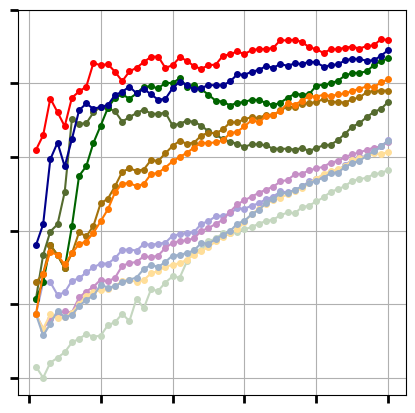

2


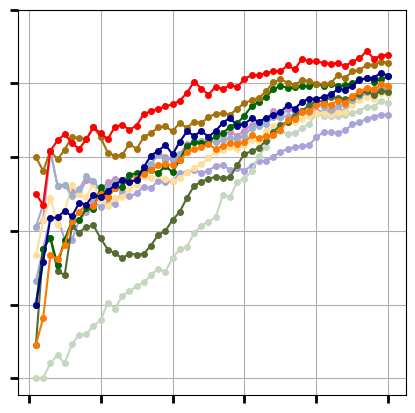

5


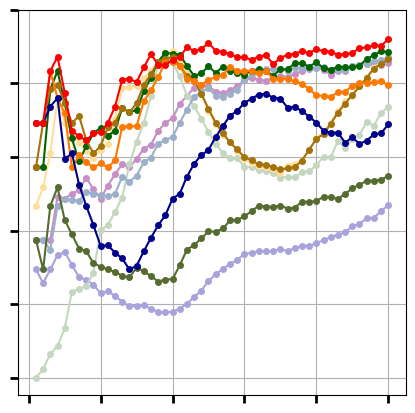

9


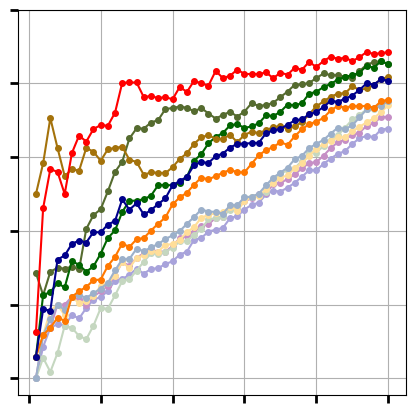

11


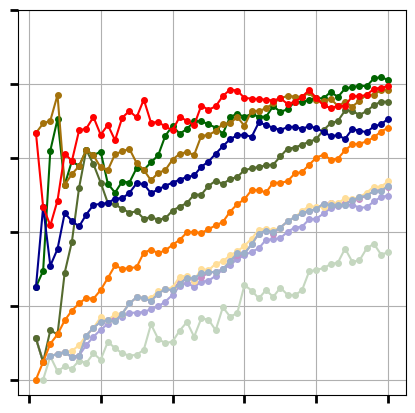

15


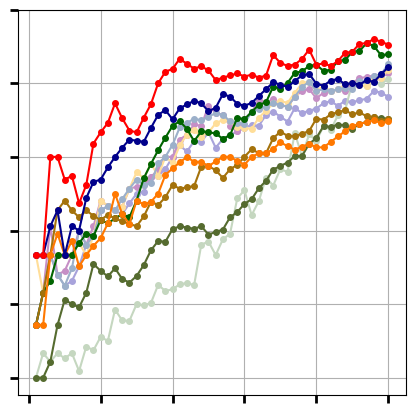

14


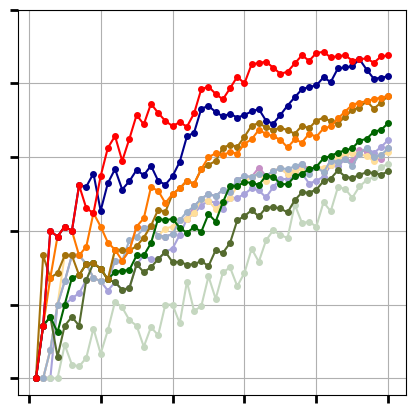

In [18]:
# jaccardDic
methods_plt = [ 'clsBetweenness', 'clsCloseness', 
               'clsKcore',  'KMcore_g1', 'KMcore_gf',
            'clsEigenvector','nodeEdgeEigenvector_linear', 'nodeEdgeEigenvector_max', 
             'degree','neiNodesNum', 'new_neiNodeSum_1']
labels = {'new_precise_t1':'t1',
          'new_neiNodeSum_1':'MIS', 
          'degree':'Degree',
          'clsBetweenness':'Betweenness', 
          'clsCloseness':'Closeness', 
          'clsKcore':'K-coreness', 
          'clsEigenvector':'Eigenvector', 
          'KMcore_g1':'H-coreness-R', 
          'KMcore_gf':'H-coreness-$R_w$', 
          'neiNodesNum':'NNum', 
          'nodeEdgeEigenvector_linear':'NEE_linear', 
          'nodeEdgeEigenvector_max':'NEE_max',}
title_netname = {1:'congress-bills',2:'house-committees',3:'algebra-questions',4:'geometry-questions',5:'music-review',
                 6:'senate-bills', 7:'senate-committees', 8:'email-Enron',9:'email-EU', 10:'Elem1',
                 11:'Mid1',12:'InVS15',13:'LH10',14:'LyonSchool',15:'SFHH',
                 16:'Thiers13', 17:'M_PL_015_ins', 18:'M_PL_015-pI', 19:'M PL_062_ins', 20:'M _PL_062-pl'}
marker = 'o'
size = 4
me = 1
fontsize1 = 16
fontsize2 = 18
fontsize3 = 18
fontweight = 'bold'
for n in [1,2,5,9,11,15,14]:# range(1,21):
    print(n)
    plt.figure(figsize=(5,5))
    if nodeNumDic[n]>=4*len(fLst):
        plt.plot(fLst, jaccardDic[n]['clsBetweenness'], label = labels['clsBetweenness'],
                 color=colors['clsBetweenness'], marker=marker, markersize= size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['clsCloseness'], label = labels['clsCloseness'] ,
                 color=colors['clsCloseness'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['clsKcore'], label = labels['clsKcore'],
                 color=colors['clsKcore'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['clsEigenvector'], label = labels['clsEigenvector'],
                 color=colors['clsEigenvector'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['neiNodesNum'], label = labels['neiNodesNum'],
                 color=colors['neiNodesNum'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['KMcore_g1'], label = labels['KMcore_g1'],
                 color=colors['KMcore_g1'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['KMcore_gf'], label = labels['KMcore_gf'],
                 color=colors['KMcore_gf'] , marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['nodeEdgeEigenvector_linear'], label = labels['nodeEdgeEigenvector_linear'],
                 color=colors['nodeEdgeEigenvector_linear'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['nodeEdgeEigenvector_max'], label = labels['nodeEdgeEigenvector_max'],
                 color=colors['nodeEdgeEigenvector_max'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['degree'], label = labels['degree'],
                 color=colors['degree'], marker=marker, markersize=size, markevery=me)
        plt.plot(fLst, jaccardDic[n]['new_neiNodeSum_1'], label = labels['new_neiNodeSum_1'],
                 color=colors['new_neiNodeSum_1'], marker=marker, markersize=size, markevery=me)

        plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5])
        plt.yticks([0.0,0.2,0.4,0.6,0.8,1.0])
        plt.tick_params(axis='y', labelsize=fontsize1)  
        plt.tick_params(axis='x', labelsize=fontsize1)
        plt.tick_params(axis='y', which='major', size=6, width=2)  
        plt.tick_params(axis='x', which='major', size=6, width=2)  
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])
        plt.grid()

        plt.savefig(f'savefig_all/main/jac_net{n}_grid.svg', format='svg', bbox_inches='tight',dpi=300)
        plt.show()
    else:
        print(11111111111)